In [577]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50, VGG19, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM, SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import seaborn as sns


In [578]:
# Loading the data

X_labeled = np.load("Xtrain1.npy")
X_unlabeled = np.load("Xtrain1_extra.npy")
Y_train_labeled = np.load("Ytrain1.npy")
X_test = np.load("Xtest1.npy")

(2783, 2304)
(904, 2304)


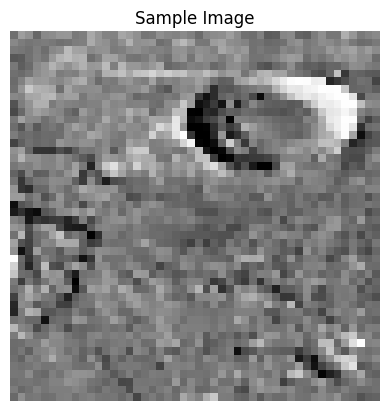

In [579]:
# Checking the shape of the data

print(X_labeled.shape)
print(X_unlabeled.shape)

# Normalization

X_labeled = X_labeled/255
X_unlabeled = X_unlabeled/255
X_test = X_test/255

# Turning the data into 2D

resized = np.resize(X_labeled[1], [48,48])
plt.imshow(resized, cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()

In [580]:
# Data Imbalance

crater_images = sum(Y_train_labeled)
no_crater_images = len(Y_train_labeled) - crater_images
ratio_no_crater_crater = no_crater_images/crater_images
print("Number of crater images: ", crater_images)
print("Number of no crater images: ", no_crater_images)
print("Ratio no crater/crater: ", ratio_no_crater_crater)

# Class Weights

class_weights_first = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_labeled), y=Y_train_labeled.flatten())
class_weight_dict_first = dict(enumerate(class_weights_first))
print("Class weights: ", class_weight_dict_first)

Number of crater images:  1777
Number of no crater images:  1006
Ratio no crater/crater:  0.566122678671919
Class weights:  {0: 1.3832007952286283, 1: 0.7830613393359594}


In [581]:
# Reshaping and Data Splitting

X_train_reshaped = X_labeled.reshape(len(X_labeled), 48, 48, 1)
X_unlabeled_train = X_unlabeled.reshape(len(X_unlabeled), 48, 48, 1)
X_test_reshaped = X_test.reshape(len(X_test), 48, 48, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_reshaped, Y_train_labeled, test_size=0.2, random_state=42)

Methods for Data Imbalance: Data Augmentation only on Minority Class

Data augmentation is a technique that can be used to improve the robustness and accuracy of a machine learning model by creating additional examples from the original dataset.

https://www.picsellia.com/post/improve-imbalanced-datasets-in-computer-vision


In [582]:
majority_indices = np.where(Y_train == 1)[0]
minority_indices = np.where(Y_train == 0)[0]

X_train_majority = X_train[majority_indices]
X_train_minority = X_train[minority_indices]

target_minority_samples = len(X_train_majority)
num_augmented_samples = target_minority_samples - len(X_train_minority)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_minority_images = []
for i in range(num_augmented_samples):
    img = X_train_minority[i % len(X_train_minority)].reshape((1, 48, 48, 1))
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_minority_images.append(augmented_img)

X_train_minority_balanced = np.concatenate([X_train_minority, np.array(augmented_minority_images)])
Y_train_minority_balanced = np.zeros(len(X_train_minority_balanced))

X_train_balanced_DA = np.concatenate([X_train_majority, X_train_minority_balanced])
Y_train_balanced_DA = np.concatenate([np.ones(len(X_train_majority)), Y_train_minority_balanced])

indices = np.arange(len(Y_train_balanced_DA))
np.random.shuffle(indices)
X_train_balanced_DA, Y_train_balanced_DA = X_train_balanced_DA[indices], Y_train_balanced_DA[indices]

print("Balanced training set shape:", X_train_balanced_DA.shape)
print("Balanced class distribution:", np.bincount(Y_train_balanced_DA.astype(int)))

Balanced training set shape: (2814, 48, 48, 1)
Balanced class distribution: [1407 1407]


Methods for Data Imbalance: Random Sampling

https://medium.com/@shubhamgupta.3101994/addressing-data-imbalance-in-image-classification-techniques-and-strategies-b922fb3c5124
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

 - Random Oversampling: Randomly duplicate examples in the minority class.
 - Random Undersampling: Randomly delete examples in the majority class.

Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random Over Sampling (ROS)

In [583]:
X_train_flattened = X_train.reshape(len(X_train), -1)
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_ROS, Y_train_ROS = ros.fit_resample(X_train_flattened, Y_train)
X_train_ROS = X_train_ROS.reshape(-1, 48, 48, 1)
unique, counts = np.unique(Y_train_ROS, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))


print(X_train_ROS.shape)
print(Y_train_ROS.shape)

Balanced class distribution: {0: 1407, 1: 1407}
(2814, 48, 48, 1)
(2814,)


Random Under Sampling (RUS)

In [584]:
X_train_flattened = X_train.reshape(len(X_train), -1)

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_RUS, Y_train_RUS = rus.fit_resample(X_train_flattened, Y_train)
X_train_RUS = X_train_RUS.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_RUS, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))

Balanced class distribution: {0: 819, 1: 819}


Combination of ROS and RUS

In [585]:
X_train_flattened = X_train.reshape(len(X_train), -1)

ros = RandomOverSampler(sampling_strategy=0.95, random_state=42)

X_train_over, Y_train_over = ros.fit_resample(X_train_flattened, Y_train)

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_train_both, Y_train_both = rus.fit_resample(X_train_over, Y_train_over)

X_train_both = X_train_both.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_over, return_counts=True)

X_val, X_model_test, Y_val, Y_model_test = train_test_split(X_val,Y_val, test_size=0.5, random_state=42)

print("Final balanced class distribution:", dict(zip(unique, counts)))

Final balanced class distribution: {0: 1336, 1: 1407}


In [548]:
# Train the model
batch_size = 32
epochs = 100

datagen.flow(X_train_ROS, Y_train_ROS, batch_size=batch_size)
augmented_images = []
augmented_labels = []

# Define how many augmented images you want to generate
num_augmented_images = 100  # Adjust this number as needed

# Loop through batches of augmented data
for X_batch, Y_batch in datagen.flow(X_train_both, Y_train_both, batch_size=batch_size):
    augmented_images.append(X_batch)
    augmented_labels.append(Y_batch)
    
    # Break once we have enough augmented images
    if len(augmented_images) * batch_size >= num_augmented_images:
        break

# Convert lists to numpy arrays
augmented_images = np.concatenate(augmented_images)[:num_augmented_images]
augmented_labels = np.concatenate(augmented_labels)[:num_augmented_images]

# Concatenate augmented data with original data
X_train_combined = np.concatenate((X_train_ROS, augmented_images), axis=0)
Y_train_combined = np.concatenate((Y_train_ROS, augmented_labels), axis = 0)

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_110"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_363 (Conv2D)             │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_363               │ (None, 23, 23, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_364 (Conv2D)             │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_364               │ (None, 10, 10, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_365 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_365               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_128 (Flatten)           │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_281 (Dense)               │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_184 (Dropout)           │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_282 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,273 (618.25 KB)

 Trainable params: 158,273 (618.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5124 - loss: 0.6975 - val_accuracy: 0.8165 - val_loss: 0.6689
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6344 - loss: 0.6568 - val_accuracy: 0.5935 - val_loss: 0.6438
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.7557 - loss: 0.5505 - val_accuracy: 0.8309 - val_loss: 0.4123
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7906 - loss: 0.4917 - val_accuracy: 0.8129 - val_loss: 0.4102
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8067 - loss: 0.4610 - val_accuracy: 0.8237 - val_loss: 0.4036
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8050 - loss: 0.4356 - val_accuracy: 0.8237 - val_loss: 0.3997
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8374 - loss: 0.4050 - val_accuracy: 0.8525 - val_loss: 0.3351
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8599 - loss: 0.3656 - val_accuracy: 0.

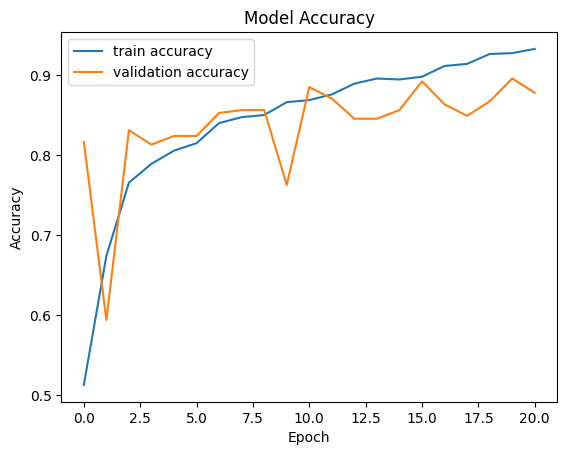

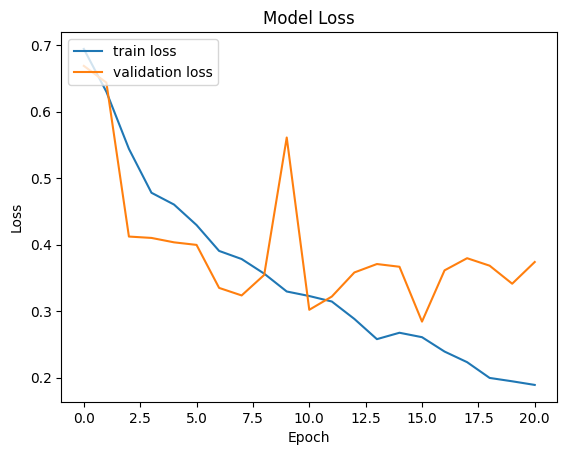

In [549]:
# # Build CNN model
def create_model():
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
 


    # # Convolutional Layer 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    # Convolutional Layer 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())

    # Fully connected layer with dropout
  
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.8))

 
    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # NAO MEXE, NAO MUDA, NAO RESPIRA
    # Compile the model
    model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model



model = create_model()
model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_both), y=Y_train_both)
class_weights_dict = dict(enumerate(class_weights))


history = model.fit(
    X_train_both, Y_train_both,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weights_dict

    )

# Evaluate the model
val_preds = model.predict(X_model_test)
#val_preds = model.predict(X_val)

val_preds = np.round(val_preds)
print(val_preds)

# Classification report
print(classification_report(Y_model_test, val_preds))
print(X_val.shape)
print(Y_val.shape)
# F1 Score
f1 = f1_score(Y_model_test, val_preds, average = 'macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_model_test, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


Pre-Trained VGG19

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 298ms/step - accuracy: 0.8178 - loss: 0.4082 - val_accuracy: 0.8849 - val_loss: 0.2674
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.8914 - loss: 0.2670 - val_accuracy: 0.8417 - val_loss: 0.3945
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 24s 289ms/step - accuracy: 0.9073 - loss: 0.2261 - val_accuracy: 0.8777 - val_loss: 0.2927
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 321ms/step - accuracy: 0.9184 - loss: 0.1858 - val_accuracy: 0.8741 - val_loss: 0.3061
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 27s 319ms/step - accuracy: 0.9213 - loss: 0.1811 - val_accuracy: 0.8993 - val_loss: 0.2735
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9276 - loss: 0.1702 - val_accuracy: 0.9029 - val_loss: 0.2304
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9499 - loss: 0.1239 - val_accuracy: 0.8921 - val_loss: 0.2679
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9570 - loss: 0.1183 - val_accu

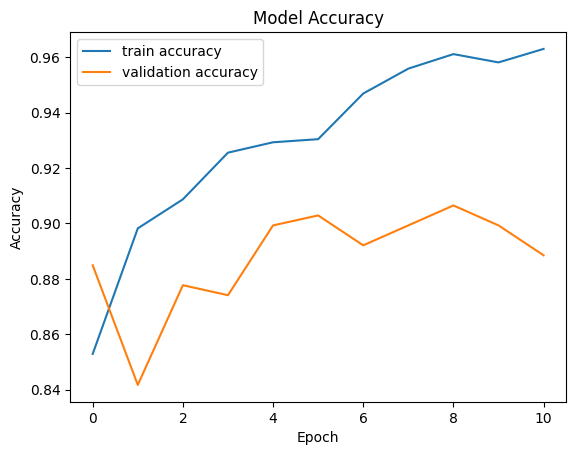

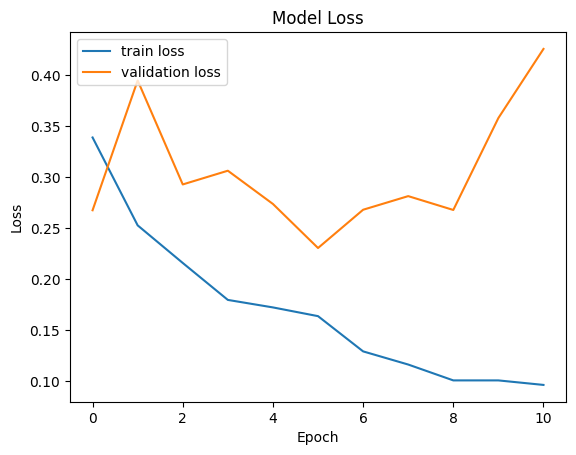

In [274]:
X_train_rgb = np.repeat(X_train_both, 3, axis=-1)  # Converts (48, 48, 1) to (48, 48, 3)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_model_rgb = np.repeat(X_model_test, 3, axis=-1) 

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the initial layers of VGG19 to retain pre-trained features
for layer in base_model.layers[:-4]:  # Adjust number of layers to unfreeze more, if necessary
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = Flatten()(x)
x= Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_rgb, Y_train_both, 
    batch_size=32,
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_model_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_model_test, val_preds))

# F1 Score
f1 = f1_score(Y_model_test, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_model_test, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Pre-trained VGG16

Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


84/84 ━━━━━━━━━━━━━━━━━━━━ 46s 526ms/step - accuracy: 0.7866 - loss: 0.4388 - val_accuracy: 0.8885 - val_loss: 0.2394
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 594ms/step - accuracy: 0.8791 - loss: 0.2798 - val_accuracy: 0.9065 - val_loss: 0.2032
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 55s 657ms/step - accuracy: 0.8899 - loss: 0.2717 - val_accuracy: 0.9173 - val_loss: 0.1763
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 604ms/step - accuracy: 0.9160 - loss: 0.2197 - val_accuracy: 0.8813 - val_loss: 0.2613
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 609ms/step - accuracy: 0.9044 - loss: 0.2305 - val_accuracy: 0.9245 - val_loss: 0.1757
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       102
           1       0.94      0.87      0.91       177

    accuracy                           0.89       279
   macro avg       0.87      0.89      0.88       279
weighted avg       0.89      0.89      0.89       279



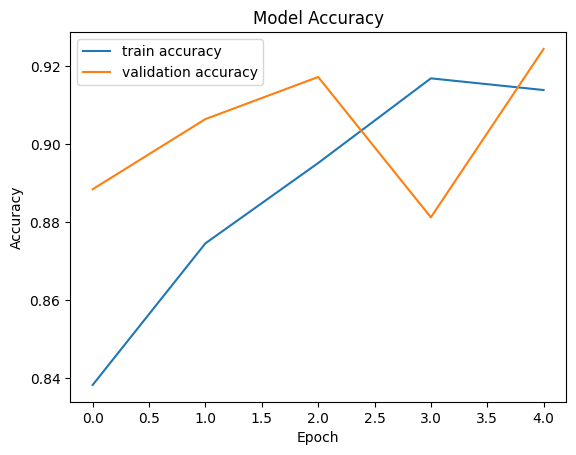

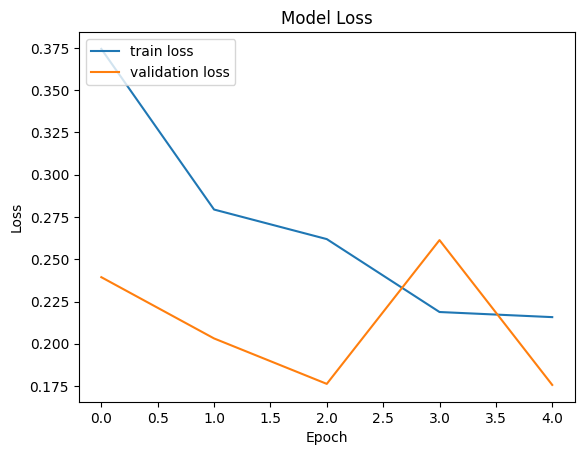

In [277]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers[:-12]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    datagen.flow(X_train_rgb, Y_train_both,batch_size=32), 
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_model_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_model_test, val_preds))

# F1 Score
f1 = f1_score(Y_model_test, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_model_test, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Unsupervised Learning (Ribeiro's version)

In [550]:
train_preds = model.predict(X_unlabeled_train)

confident_indices = []
pseudo_labels = []

for i, pred in enumerate(train_preds):
    if pred > 0.99:  # Confidently positive
        confident_indices.append(i)  # Store the index
        pseudo_labels.append(1)  # Store the pseudo-label as 1
    elif pred < 0.01:  # Confidently negative
        confident_indices.append(i)  # Store the index
        pseudo_labels.append(0)  # Store the pseudo-label as 0

pseudo_labels = np.array(pseudo_labels)  # Convert to NumPy array
print("Pseudo labels shape:", pseudo_labels.shape)

# Only keep confident predictions (those with pseudo-labels not equal to -1)
confident_indices = np.array(confident_indices)  # Convert to NumPy array to ensure proper indexing
confident_indices = confident_indices[confident_indices < len(pseudo_labels)]  # Ensure indices are within bounds

X_confident = X_unlabeled_train[confident_indices]
pseudo_labels_confident = pseudo_labels[confident_indices]
pseudo_labels_confident = pseudo_labels_confident.ravel()

X_combined = np.concatenate((X_train_both, X_confident), axis=0)
y_combined = np.concatenate((Y_train_both, pseudo_labels_confident), axis=0)

class_weights_combined = compute_class_weight('balanced', classes=np.unique(y_combined), y=y_combined)
class_weights_dict_combined = dict(enumerate(class_weights_combined))

model = create_model()

# Train the model

history = model.fit(
    X_combined, y_combined,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=batch_size,
    #callbacks=[early_stopping],
    class_weight=class_weights_dict_combined
)

y_pred_new = model.predict(X_model_test)
y_pred_new = np.round(y_pred_new)
print(classification_report(Y_model_test, y_pred_new))

# F1 Score
f1 = f1_score(Y_model_test, y_pred_new, average = 'macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_model_test, y_pred_new)
print("Confusion Matrix:\n", conf_matrix)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Pseudo labels shape: (124,)
Epoch 1/30


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


85/85 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5176 - loss: 0.6970 - val_accuracy: 0.7842 - val_loss: 0.6270
Epoch 2/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6538 - loss: 0.6513 - val_accuracy: 0.7050 - val_loss: 0.5582
Epoch 3/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7692 - loss: 0.5388 - val_accuracy: 0.7950 - val_loss: 0.4521
Epoch 4/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8035 - loss: 0.4776 - val_accuracy: 0.8201 - val_loss: 0.4170
Epoch 5/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8130 - loss: 0.4400 - val_accuracy: 0.7518 - val_loss: 0.5289
Epoch 6/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.8039 - loss: 0.4411 - val_accuracy: 0.8453 - val_loss: 0.3882
Epoch 7/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.8455 - loss: 0.3719 - val_accuracy: 0.8813 - val_loss: 0.3063
Epoch 8/30
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8373 - loss: 0.3947 - val_accuracy: 0.8453 - val_loss: 0.

Using CV and the new training set (labeled +  labeled through self-learning)

Training on Fold 1...
Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 4/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5931 - loss: 0.6820

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5201 - loss: 0.6961 - val_accuracy: 0.4794 - val_loss: 0.6905
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5567 - loss: 0.6839 - val_accuracy: 0.6030 - val_loss: 0.6785
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7136 - loss: 0.6377 - val_accuracy: 0.6199 - val_loss: 0.8869
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7430 - loss: 0.5697 - val_accuracy: 0.7584 - val_loss: 0.6071
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7605 - loss: 0.5570 - val_accuracy: 0.7060 - val_loss: 0.7417
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7682 - loss: 0.5418 - val_accuracy: 0.6835 - val_loss: 0.7724
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7784 - loss: 0.5161 - val_accuracy: 0.6798 - val_loss: 0.8687
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7811 - loss: 0.5181 - val_accuracy: 0.7116 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 7/67 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.4438 - loss: 0.6991 

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.4915 - loss: 0.6981 - val_accuracy: 0.4981 - val_loss: 0.6925
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5121 - loss: 0.6931 - val_accuracy: 0.5075 - val_loss: 0.6929
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5480 - loss: 0.6917 - val_accuracy: 0.5805 - val_loss: 0.6831
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5497 - loss: 0.6780 - val_accuracy: 0.6311 - val_loss: 0.6857
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6569 - loss: 0.6092 - val_accuracy: 0.7191 - val_loss: 0.6034
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.6752 - loss: 0.5833 - val_accuracy: 0.6966 - val_loss: 0.6166
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7119 - loss: 0.5733 - val_accuracy: 0.6929 - val_loss: 0.6564
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7126 - loss: 0.5409 - val_accuracy: 0.7453 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 6/67 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5472 - loss: 0.6891

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5298 - loss: 0.6926 - val_accuracy: 0.5207 - val_loss: 0.6877
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5348 - loss: 0.6876 - val_accuracy: 0.7650 - val_loss: 0.6247
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6726 - loss: 0.6323 - val_accuracy: 0.8083 - val_loss: 0.5065
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6954 - loss: 0.6264 - val_accuracy: 0.7820 - val_loss: 0.5631
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7620 - loss: 0.5446 - val_accuracy: 0.7932 - val_loss: 0.5030
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7554 - loss: 0.5417 - val_accuracy: 0.7331 - val_loss: 0.6528
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7763 - loss: 0.4918 - val_accuracy: 0.7481 - val_loss: 0.5270
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7835 - loss: 0.5014 - val_accuracy: 0.7895 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 4/67 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5260 - loss: 0.7009  

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.4735 - loss: 0.7021 - val_accuracy: 0.6791 - val_loss: 0.6888
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5237 - loss: 0.6897 - val_accuracy: 0.5075 - val_loss: 0.7659
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6848 - loss: 0.6470 - val_accuracy: 0.7164 - val_loss: 0.8048
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7498 - loss: 0.6034 - val_accuracy: 0.7146 - val_loss: 0.7358
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7595 - loss: 0.5487 - val_accuracy: 0.6940 - val_loss: 0.7712
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7622 - loss: 0.5340 - val_accuracy: 0.7388 - val_loss: 0.5284
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7771 - loss: 0.5114 - val_accuracy: 0.6978 - val_loss: 0.6601
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7729 - loss: 0.5024 - val_accuracy: 0.7276 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 1/67 ━━━━━━━━━━━━━━━━━━━━ 1:17 1s/step - accuracy: 0.4583 - loss: 0.6956

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.4904 - loss: 0.6953 - val_accuracy: 0.5093 - val_loss: 0.6836
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5740 - loss: 0.6864 - val_accuracy: 0.6175 - val_loss: 0.6683
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.6564 - loss: 0.6492 - val_accuracy: 0.6679 - val_loss: 0.8379
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7119 - loss: 0.6147 - val_accuracy: 0.7351 - val_loss: 0.6946
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7389 - loss: 0.5731 - val_accuracy: 0.8004 - val_loss: 0.4972
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7674 - loss: 0.5298 - val_accuracy: 0.8060 - val_loss: 0.4487
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7599 - loss: 0.5355 - val_accuracy: 0.7873 - val_loss: 0.4811
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7664 - loss: 0.5326 - val_accuracy: 0.6381 - val_loss: 0.

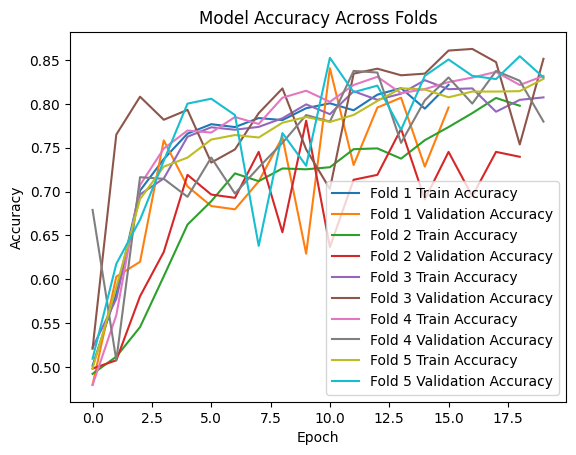

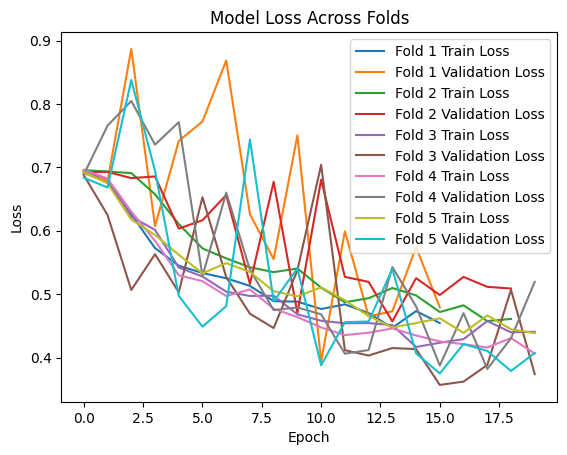

In [554]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_combined):
    print(f"Training on Fold {fold}...")

    # Ensure indices are within bounds
    train_index = train_index[train_index < len(X_train_both)]
    val_index = val_index[val_index < len(X_train_both)]

    # Split the data into training and validation sets
    X_train_cv, X_val_cv = X_combined[train_index], X_combined[val_index]
    y_train_cv, y_val_cv = y_combined[train_index], y_combined[val_index]

    
    # Create a new CNN model for each fold
    model = create_model()
    
    early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5, 
    restore_best_weights=True  
    )

    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train_cv, y_train_cv, batch_size=32), 
        validation_data=(X_val_cv.reshape(X_val_cv.shape[0], 48, 48, 1), y_val_cv),  # Ensure X_val has shape (48, 48, 1)
        epochs=20,
        callbacks = [early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_model_test.reshape(X_model_test.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(Y_model_test, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(Y_model_test, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

CV in original data

Training on Fold 1...
Epoch 1/20


/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 3/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.5052 - loss: 0.6899

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.4948 - loss: 0.6947 - val_accuracy: 0.4935 - val_loss: 0.6889
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5239 - loss: 0.6862 - val_accuracy: 0.7402 - val_loss: 0.6260
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6784 - loss: 0.6366 - val_accuracy: 0.5925 - val_loss: 0.8472
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6985 - loss: 0.5757 - val_accuracy: 0.6150 - val_loss: 0.6405
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7187 - loss: 0.5456 - val_accuracy: 0.7215 - val_loss: 0.5452
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7295 - loss: 0.5276 - val_accuracy: 0.6037 - val_loss: 0.7264
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6957 - loss: 0.5421 - val_accuracy: 0.7402 - val_loss: 0.5300
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7132 - loss: 0.5204 - val_accuracy: 0.6355 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 3/67 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.5521 - loss: 0.6891

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5269 - loss: 0.6936 - val_accuracy: 0.5271 - val_loss: 0.6704
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6209 - loss: 0.6750 - val_accuracy: 0.7533 - val_loss: 0.6073
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.6894 - loss: 0.6172 - val_accuracy: 0.6916 - val_loss: 0.6453
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7152 - loss: 0.5734 - val_accuracy: 0.7458 - val_loss: 0.5586
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.7261 - loss: 0.5433 - val_accuracy: 0.7402 - val_loss: 0.5470
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7331 - loss: 0.5446 - val_accuracy: 0.7944 - val_loss: 0.4851
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.7669 - loss: 0.5173 - val_accuracy: 0.7514 - val_loss: 0.5425
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7556 - loss: 0.5213 - val_accuracy: 0.8224 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 2/67 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6406 - loss: 0.6888

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.5132 - loss: 0.6955 - val_accuracy: 0.5094 - val_loss: 0.6895
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5116 - loss: 0.6859 - val_accuracy: 0.7079 - val_loss: 0.6565
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7284 - loss: 0.6276 - val_accuracy: 0.7060 - val_loss: 1.0147
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7561 - loss: 0.5298 - val_accuracy: 0.7341 - val_loss: 0.6795
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8013 - loss: 0.4973 - val_accuracy: 0.7004 - val_loss: 0.7783
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7716 - loss: 0.5440 - val_accuracy: 0.7491 - val_loss: 0.5959
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7836 - loss: 0.4752 - val_accuracy: 0.7528 - val_loss: 0.5204
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7783 - loss: 0.4854 - val_accuracy: 0.7884 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 6/67 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5535 - loss: 0.6868

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.5088 - loss: 0.6973 - val_accuracy: 0.4869 - val_loss: 0.6912
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5502 - loss: 0.6879 - val_accuracy: 0.6292 - val_loss: 0.6588
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.6874 - loss: 0.6390 - val_accuracy: 0.7060 - val_loss: 0.6733
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7181 - loss: 0.5825 - val_accuracy: 0.6948 - val_loss: 0.6876
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7436 - loss: 0.5500 - val_accuracy: 0.7004 - val_loss: 0.5998
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.7407 - loss: 0.5202 - val_accuracy: 0.6442 - val_loss: 0.8223
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7336 - loss: 0.5335 - val_accuracy: 0.7360 - val_loss: 0.5279
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7486 - loss: 0.5172 - val_accuracy: 0.7678 - val_loss: 0.

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


 5/67 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5558 - loss: 0.7037

/opt/homebrew/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5128 - loss: 0.7000 - val_accuracy: 0.5131 - val_loss: 0.6915
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5264 - loss: 0.6904 - val_accuracy: 0.5674 - val_loss: 0.6751
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6584 - loss: 0.6661 - val_accuracy: 0.7622 - val_loss: 0.5855
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7022 - loss: 0.6097 - val_accuracy: 0.7116 - val_loss: 0.8955
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7564 - loss: 0.5656 - val_accuracy: 0.7828 - val_loss: 0.4948
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7437 - loss: 0.5443 - val_accuracy: 0.7622 - val_loss: 0.7144
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7640 - loss: 0.5217 - val_accuracy: 0.8090 - val_loss: 0.4531
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7725 - loss: 0.5076 - val_accuracy: 0.6554 - val_loss: 0.

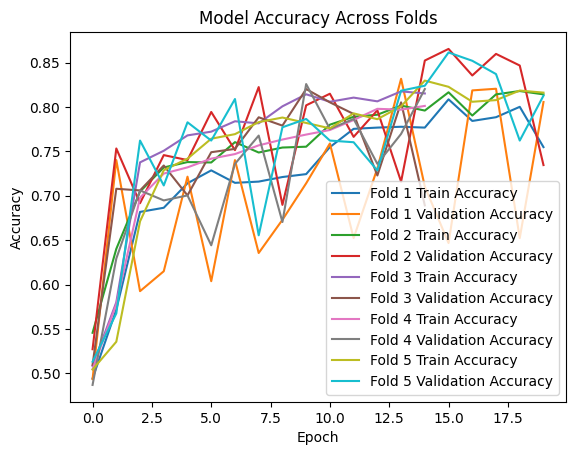

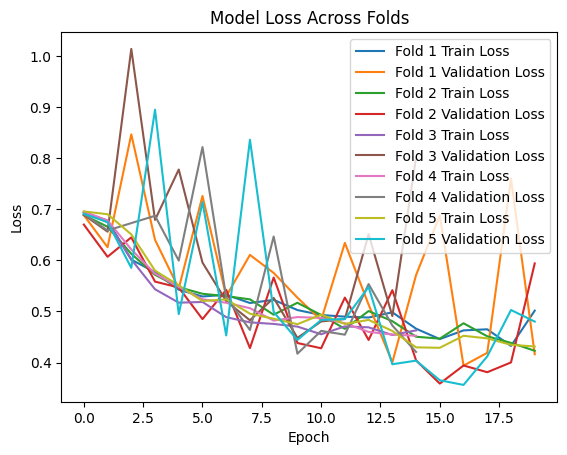

In [555]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_train_both):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train_cv2, X_val_cv2 = X_train_both[train_index], X_train_both[val_index]
    y_train_cv2, y_val_cv2 = Y_train_both[train_index], Y_train_both[val_index]
    
    # Create a new CNN model for each fold
    model = create_model()

    early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5, 
    restore_best_weights=True  
    )
    
    # Train the model with data augmentation
    history = model.fit(
        datagen.flow(X_train_cv2, y_train_cv2, batch_size=32), 
        validation_data=(X_val_cv2.reshape(X_val_cv2.shape[0], 48, 48, 1), y_val_cv2),  # Ensure X_val has shape (48, 48, 1)
        epochs=20,
        callbacks = [early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_model_test.reshape(X_model_test.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(Y_model_test, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(Y_model_test, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Using a CNN for feature extraction and training the model with a DNN

Training on Fold 1...
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Shape of y_train_binary after reshaping: (2137, 1)
Shape of y_val_binary after reshaping: (535, 1)
Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5075 - loss: 0.6984 - val_accuracy: 0.4935 - val_loss: 0.6877
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5248 - loss: 0.6912 - val_accuracy: 0.5065 - val_loss: 0.6796
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5640 - loss: 0.6816 - val_accuracy: 0.7364 - val_loss: 0.6599
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 0.6586 - val_accuracy: 0.7252 - val_loss: 0.6232
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6581 - loss: 0.6410 - val_accuracy: 0.7458 - val_loss: 0.5904
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6784 - loss: 0.6100 - val_accuracy: 0.7364 - val_loss: 0.5693
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/

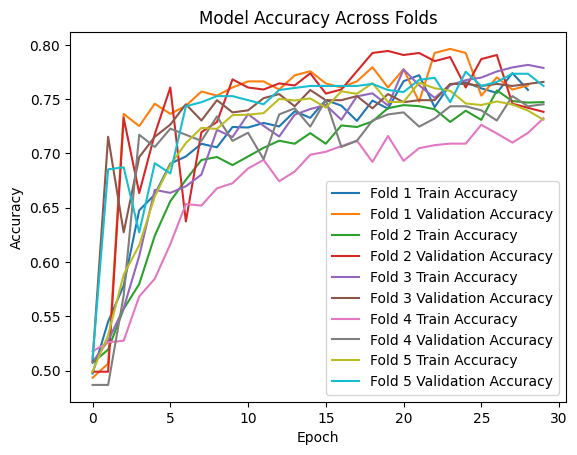

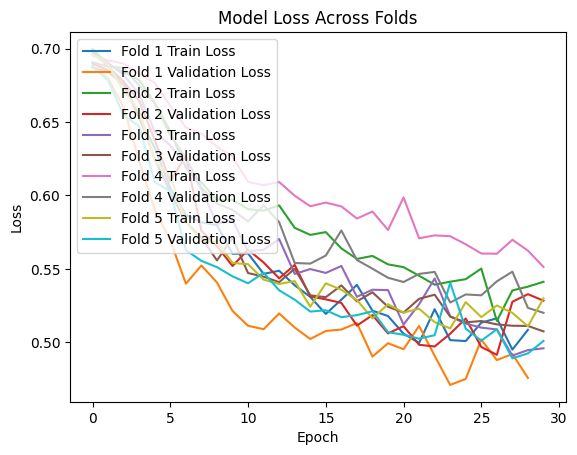

In [282]:
# Using reshaped training data (labeled)
x_label = X_train_both  # original labeled data (training set)
y_label = Y_train_both  # original labeled data (labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Build the CNN feature extractor model
def create_cnn_feature_extractor():
    inputs = Input(shape=(48, 48, 1))
    
    # Convolutional Layer 1
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening
    x = Flatten()(x)

    return Model(inputs, x)

# Build the DNN model
def create_dnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    return Model(inputs, outputs)

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(x_label):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = x_label[train_index], x_label[val_index]
    y_train, y_val = y_label[train_index], y_label[val_index]  # Corrected

    # Convert labels to binary (0 or 1)
    y_train_binary = np.round(y_train).astype(int)  # Binary labels
    y_val_binary = np.round(y_val).astype(int)

    # Shuffle the resampled training data
    X_train, y_train_binary = shuffle(X_train, y_train_binary, random_state=42)
    
    # Reshape the validation data to match CNN input
    X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
    X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train)
    cnn_features_val = cnn_feature_extractor.predict(X_val)
    
    # Flatten the CNN features
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor
        patience=5,             # Number of epochs to wait for improvement
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Ensure that y_train_binary and y_val_binary are reshaped to (batch_size, 1)
    y_train_binary = y_train_binary.reshape((-1, 1))
    y_val_binary = y_val_binary.reshape((-1, 1))

    print("Shape of y_train_binary after reshaping:", y_train_binary.shape)
    print("Shape of y_val_binary after reshaping:", y_val_binary.shape)

    # Train the DNN model
    history = dnn_model.fit(
        cnn_features_train, y_train_binary,
        validation_data=(cnn_features_val, y_val_binary),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds).astype(int)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val_binary, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val_binary, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


CNN + DNN + Unlabeled data

Training on Fold 1...
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Shape of y_train_binary after reshaping: (2143, 1)
Shape of y_val_binary after reshaping: (536, 1)
Epoch 1/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5479 - loss: 0.6839 - val_accuracy: 0.5821 - val_loss: 0.6622
Epoch 2/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5989 - loss: 0.6676 - val_accuracy: 0.5821 - val_loss: 0.6528
Epoch 3/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5951 - loss: 0.6542 - val_accuracy: 0.5821 - val_loss: 0.6308
Epoch 4/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 0.6348 - val_accuracy: 0.7575 - val_loss: 0.6074
Epoch 5/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6710 - loss: 0.6031 - val_accuracy: 0.7836 - val_loss: 0.5738
Epoch 6/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7494 - loss: 0.5898 - val_accuracy: 0.7780 - val_loss: 0.5406
Epoch 7/30
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

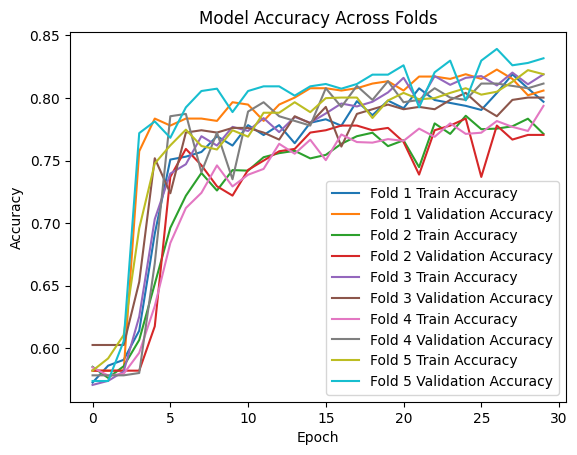

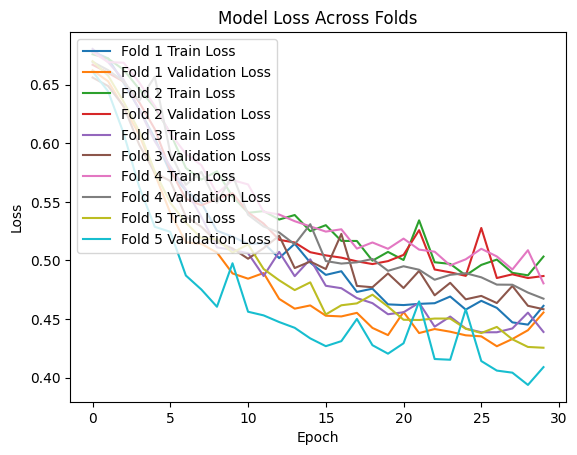

In [283]:
# Using reshaped training data (labeled)
x_label = X_combined  # original labeled data (training set)
y_label = y_combined  # original labeled data (labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []


# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(x_label):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = x_label[train_index], x_label[val_index]
    y_train, y_val = y_label[train_index], y_label[val_index]  # Corrected

    # Convert labels to binary (0 or 1)
    y_train_binary = np.round(y_train).astype(int)  # Binary labels
    y_val_binary = np.round(y_val).astype(int)

    # Shuffle the resampled training data
    X_train, y_train_binary = shuffle(X_train, y_train_binary, random_state=42)
    
    # Reshape the validation data to match CNN input
    X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
    X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train)
    cnn_features_val = cnn_feature_extractor.predict(X_val)
    
    # Flatten the CNN features
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor
        patience=5,             # Number of epochs to wait for improvement
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Ensure that y_train_binary and y_val_binary are reshaped to (batch_size, 1)
    y_train_binary = y_train_binary.reshape((-1, 1))
    y_val_binary = y_val_binary.reshape((-1, 1))

    print("Shape of y_train_binary after reshaping:", y_train_binary.shape)
    print("Shape of y_val_binary after reshaping:", y_val_binary.shape)

    # Train the DNN model
    history = dnn_model.fit(
        cnn_features_train, y_train_binary,
        validation_data=(cnn_features_val, y_val_binary),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds).astype(int)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val_binary, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val_binary, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


**FINAL PREDICTIONS**

/opt/homebrew/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5012 - loss: 0.6954 - val_accuracy: 0.8273 - val_loss: 0.6684
Epoch 2/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6225 - loss: 0.6405 - val_accuracy: 0.7590 - val_loss: 0.4998
Epoch 3/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7586 - loss: 0.5228 - val_accuracy: 0.7806 - val_loss: 0.4494
Epoch 4/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.7956 - loss: 0.4659 - val_accuracy: 0.8561 - val_loss: 0.3702
Epoch 5/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.8161 - loss: 0.4373 - val_accuracy: 0.8777 - val_loss: 0.3363
Epoch 6/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8192 - loss: 0.4256 - val_accuracy: 0.8489 - val_loss: 0.3723
Epoch 7/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8316 - loss: 0.3987 - val_accuracy: 0.8237 - val_loss: 0.3919
Epoch 8/100
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8361 - loss: 0.3822 - val_accuracy: 0.

(array([263.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 433.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

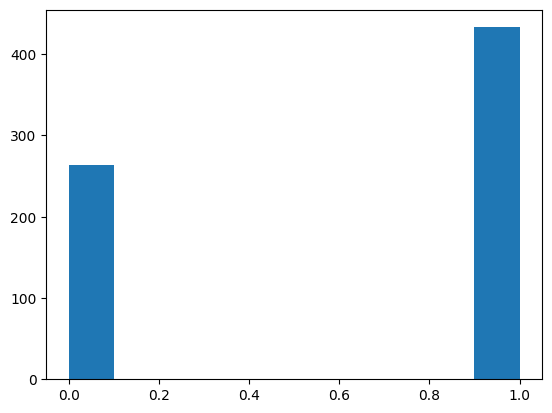

In [586]:
model = create_model()

X_final_model = np.concatenate((X_combined, X_model_test), axis=0)
Y_final_model = np.concatenate((y_combined, Y_model_test), axis=0)

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=10, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

class_weights_final = compute_class_weight('balanced', classes=np.unique(Y_final_model), y=Y_final_model)
class_weights_dict_final = dict(enumerate(class_weights_final))

model.fit(X_final_model, Y_final_model, 
          epochs=100, 
          batch_size=32, class_weight=class_weights_dict_final, 
          validation_data=(X_val, Y_val), 
          callbacks=[early_stopping])
predictions = model.predict(X_test_reshaped)
final_predictions = np.round(predictions).astype(int).flatten()



np.save("predictions.npy", final_predictions)
plt.hist(final_predictions)

In [587]:
print(final_predictions.shape)
print(np.sum(final_predictions)/len(final_predictions))

(696,)
0.6221264367816092
